In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

def append_ext(fn):
    return fn+".jpg"

traindf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Part3_GroundTruth.csv',dtype=str)
testdf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Part3_GroundTruth.csv',dtype=str)
traindf['image_id']=traindf['image_id'].apply(append_ext)
testdf['image_id']=testdf['image_id'].apply(append_ext)

In [2]:
#create a label column
label=[0]*traindf.shape[0]
for i in range(traindf.shape[0]):
    if traindf['melanoma'][i] == '1.0':
        label[i]='1'
    else:
        label[i]='0'
traindf['label']=label    

label=[0]*testdf.shape[0]
for i in range(testdf.shape[0]):
    if testdf['melanoma'][i] == '1.0':
        label[i]='1'
    else:
        label[i]='0'
testdf['label']=label

In [3]:
X = traindf.loc[:,'image_id']
y = traindf.loc[:,'label']

In [4]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X, y, 
                                                  test_size = 0.2, 
                                                  random_state = 27, 
                                                  stratify=y)

In [5]:
from imblearn.over_sampling import RandomOverSampler
train_x_overs, train_y_overs = RandomOverSampler(random_state=42, sampling_strategy='minority').fit_resample(train_x.values.reshape(train_x.shape[0],-1), train_y)

In [48]:
# example of random oversampling to balance the class distribution
from collections import Counter
# summarize class distribution
print(Counter(train_y))
print(Counter(train_y_overs))

Counter({'0': 1220, '1': 280})
Counter({'0': 1220, '1': 1220})


In [56]:
#df_train_upsampled = pd.DataFrame().assign(image_id=train_x_overs[:, 0], label=train_y_overs)
#print(df_train_upsampled)


df_val= pd.DataFrame(columns=['image_id','label'])
df_val['image_id'] = val_x
df_val['label'] = val_y

df_train_upsampled = pd.DataFrame(columns=['image_id','label'])
for i in range(2*len(train_x_overs)):
    if i == 1220:
        break
    else:
        if train_y_overs[i] == '0':
            df_train_upsampled=df_train_upsampled.append({'image_id': ''.join(train_x_overs[i]), 'label': train_y_overs[i] }, ignore_index=True)
            
        else:
            df_train_upsampled=df_train_upsampled.append({'image_id': ''.join(train_x_overs[i+1220]), 'label': train_y_overs[i+1220] }, ignore_index=True)
        
df_train_upsampled
#shuffle

,image_id,label
0,"['[""[\'ISIC_0014658.jpg\']""]']",0
1,"['[""[\'ISIC_0012986.jpg\']""]']",0
2,"['[""[\'ISIC_0012182.jpg\']""]']",0
3,"['[""[\'ISIC_0000408.jpg\']""]']",0
4,"['[""[\'ISIC_0014630.jpg\']""]']",0
...,...,...
1215,"['[""[\'ISIC_0011213.jpg\']""]']",0
1216,"['[""[\'ISIC_0012851.jpg\']""]']",0
1217,"['[""[\'ISIC_0000189.jpg\']""]']",0
1218,"['[""[\'ISIC_0000326.jpg\']""]']",0


In [8]:
#uncomment according to the architecture being used
# IMG_SIZE = 224 #B0
# IMG_SIZE = 240 #B1
# IMG_SIZE = 260 #B2
IMG_SIZE = 300 #B3
# IMG_SIZE = 380 #B4
# IMG_SIZE = 456 #B5
# IMG_SIZE = 528 #B6
# IMG_SIZE = 600 #B7

In [9]:
train_datagen=ImageDataGenerator(rotation_range=5,  # rotation
                                 width_shift_range=0.2,  # horizontal shift
                                 zoom_range=0.2,  # zoom
                                 horizontal_flip=True,  # horizontal flip
                                 brightness_range=[0.2,0.8] # brightness
                                 #rescale=1./255.
                                )  

train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_upsampled,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            batch_size=16,
                                            seed=42,
                                            shuffle=False,
                                            class_mode='binary',
                                            drop_duplicates = False,
                                            target_size=(IMG_SIZE,IMG_SIZE)
                                           )

valid_datagen=ImageDataGenerator()#rescale=1./255.)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=df_val,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            batch_size=16,
                                            seed=42,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(IMG_SIZE,IMG_SIZE)
                                           )

test_datagen=ImageDataGenerator()#rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=testdf,
                                                directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Data\\',
                                                x_col='image_id',
                                                y_col=None,
                                                batch_size=30,
                                                seed=40,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(IMG_SIZE,IMG_SIZE)
                                               )

Found 1217 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 600 validated image filenames.


In [10]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB3

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = inputs

    # Create the base model from the pre-trained model EfficientNet
    base_model = EfficientNetB3(include_top=False, input_tensor=x, weights="imagenet")
    for layer in base_model.layers:
        layer.trainable = False
    
    # Rebuild top
    x=base_model.output
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)#(base_model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    #x = layers.Dense(1024)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

NUM_CLASSES=1
model = build_model(num_classes=NUM_CLASSES)

model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [11]:
for l in model.layers:
    print(l.name, l.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv Fal

block7a_bn False
block7a_activation False
block7a_se_squeeze False
block7a_se_reshape False
block7a_se_reduce False
block7a_se_expand False
block7a_se_excite False
block7a_project_conv False
block7a_project_bn False
block7b_expand_conv False
block7b_expand_bn False
block7b_expand_activation False
block7b_dwconv False
block7b_bn False
block7b_activation False
block7b_se_squeeze False
block7b_se_reshape False
block7b_se_reduce False
block7b_se_expand False
block7b_se_excite False
block7b_project_conv False
block7b_project_bn False
block7b_drop False
block7b_add False
top_conv False
top_bn False
top_activation False
avg_pool True
batch_normalization True
top_dropout True
pred True


In [12]:
#how this model performs on this data before fitting
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.evaluate(valid_generator,
               steps=STEP_SIZE_VALID)

31/31 [==============================] - 106s 3s/step - loss: 0.6336 - accuracy: 0.6895


[0.6336361169815063, 0.6895161271095276]

In [13]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size

hist=model.fit(train_generator,
          epochs=12,
          validation_data=valid_generator,
          verbose=1
         )

Epoch 1/12
77/77 [==============================] - 403s 5s/step - loss: 0.7929 - accuracy: 0.5850 - val_loss: 0.7125 - val_accuracy: 0.5180
Epoch 2/12
77/77 [==============================] - 404s 5s/step - loss: 0.7067 - accuracy: 0.6228 - val_loss: 0.7069 - val_accuracy: 0.5420
Epoch 3/12
77/77 [==============================] - 406s 5s/step - loss: 0.6488 - accuracy: 0.6524 - val_loss: 0.7450 - val_accuracy: 0.5180
Epoch 4/12
77/77 [==============================] - 405s 5s/step - loss: 0.6136 - accuracy: 0.6902 - val_loss: 0.6976 - val_accuracy: 0.5840
Epoch 5/12
77/77 [==============================] - 401s 5s/step - loss: 0.6012 - accuracy: 0.6771 - val_loss: 0.7021 - val_accuracy: 0.6040
Epoch 6/12
77/77 [==============================] - 400s 5s/step - loss: 0.5905 - accuracy: 0.7083 - val_loss: 0.5961 - val_accuracy: 0.6840
Epoch 7/12
77/77 [==============================] - 400s 5s/step - loss: 0.5964 - accuracy: 0.6902 - val_loss: 0.7841 - val_accuracy: 0.5680
Epoch 8/12
77

In [14]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-18:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

model.summary()

hist=model.fit(train_generator,
          epochs=8,
          validation_data=valid_generator,
          verbose=1
         )

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 300, 300, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

Total params: 10,791,216
Trainable params: 1,923,937
Non-trainable params: 8,867,279
__________________________________________________________________________________________________
Epoch 1/8
77/77 [==============================] - 414s 5s/step - loss: 0.5811 - accuracy: 0.7141 - val_loss: 0.6513 - val_accuracy: 0.6740
Epoch 2/8
77/77 [==============================] - 410s 5s/step - loss: 0.5368 - accuracy: 0.7403 - val_loss: 0.5757 - val_accuracy: 0.7180
Epoch 3/8
77/77 [==============================] - 410s 5s/step - loss: 0.5370 - accuracy: 0.7387 - val_loss: 0.5565 - val_accuracy: 0.7180
Epoch 4/8
77/77 [==============================] - 408s 5s/step - loss: 0.4637 - accuracy: 0.7757 - val_loss: 0.5335 - val_accuracy: 0.7340
Epoch 5/8
77/77 [==============================] - 407s 5s/step - loss: 0.4605 - accuracy: 0.7905 - val_loss: 0.5536 - val_accuracy: 0.7200
Epoch 6/8
77/77 [==============================] - 415s 5s/step - loss: 0.4360 - accuracy: 0.7970 - val_loss: 0.8022

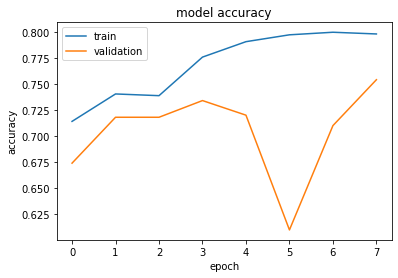

In [15]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

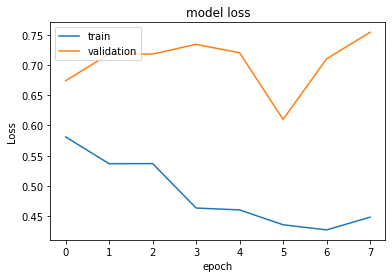

In [16]:
import matplotlib.pyplot as plt
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_accuracy"])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [17]:
#how this model performs after fitting
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.evaluate(valid_generator,
               steps=STEP_SIZE_VALID)

31/31 [==============================] - 104s 3s/step - loss: 0.5088 - accuracy: 0.7520


[0.5088467001914978, 0.7520161271095276]

In [57]:

test_generator.reset()

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
pred=model.predict(test_generator,
                   steps=STEP_SIZE_TEST,
                   verbose=1)

NameError: name 'test_generator' is not defined

In [ ]:
labels_pred=np.where(pred > 0.5, 1, 0)

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
x = test_generator.next() #this unpacks the ImageDataGenerator which is composed by x(image) and y(label). In the case of test, there are not labels
for i in range(5):
    image = x[i]
    plt.title('Predicted Label: ' + str(labels_pred[i]))
    plt.imshow(image.astype(np.uint8))
    plt.show()

In [ ]:
import sklearn
acc=sklearn.metrics.accuracy_score(testdf['label'].astype(int).to_numpy(), labels_pred)

print('Accuracy: \n' + str(acc))

In [ ]:
confusion_matrix=sklearn.metrics.confusion_matrix(testdf['label'].astype(int).to_numpy(), labels_pred)

print('Confusion Matrix: \n' + str(confusion_matrix))

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, threshold = roc_curve(testdf['label'].astype(int).to_numpy(),labels_pred)
roc_auc = metrics.auc(fpr, tpr)
print('AUC Score: ' + str(roc_auc))

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='-', label='EfficientNet B3')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
jac=sklearn.metrics.jaccard_score(testdf['label'].astype(int).to_numpy(), labels_pred)
print('Jaccard Score: ' + str(jac))

In [ ]:
model.save("EfficientNetB3_sigmoid.h5")
print("Saved model to disk")

# load model
#model = tf.keras.models.load_model('EfficientNetB3_sigmoid.h5')
#model.summary()